<a href="https://colab.research.google.com/github/Natalia409634/Grupo7-practica1-ML/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

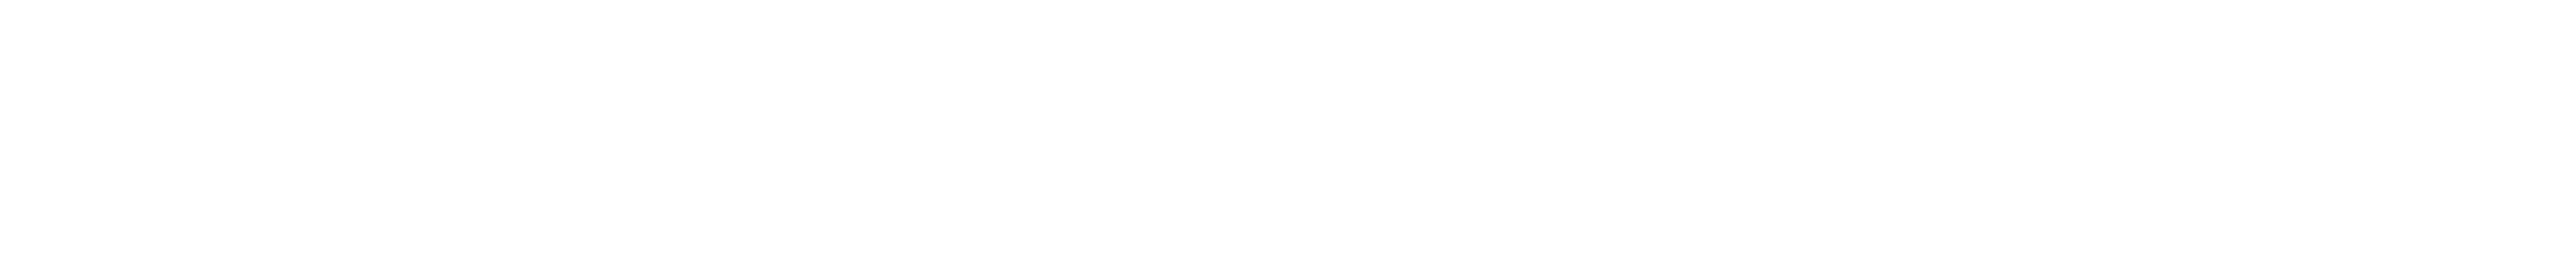

# **PRÁCTICA 1: PREDICCIÓN DE LA ENERGÍA SOLAR**


*   Aprendizaje Automático - Grupo 7
*   Andrés Felipe Camacho Martínez - 100408821
*   Natalia Jiménez Barrigüete - 100409634

# Librerías y lectura de datos

In [8]:
# Configuraciones
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')
import time

# Tratamiento de datos
# ==============================================================================
import pandas as pd   
import numpy as np
import joblib 

# Gráficos
# ==============================================================================
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Preprocesado
# ==============================================================================
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import GridSearchCV

# Modelado
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lectura de datos

In [2]:
disp_df, comp_df = [pd.read_csv(f, compression="bz2", index_col=0) for f in 
                    ["/content/drive/MyDrive/Aprendizaje Automático/datos practica/disp_st7ns1.txt.bz2",
                     "/content/drive/MyDrive/Aprendizaje Automático/datos practica/comp_st7ns1.txt.bz2"]]

In [3]:
from sklearn.model_selection import train_test_split

X = disp_df.drop(columns = ['salida'])
y = disp_df[['salida']]

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.67, random_state=7)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=7)

# Modelo Final

Para el ajuste de los parámetros en nuestro modelo final comenzaremos empleando RandomizedSearchCV.

In [29]:
from scipy.stats import randint as sp_randint

param_grid = {'n_estimators': sp_randint(10, 70),
              'max_features': sp_randint(1, X.shape[1]),
              'max_depth': [10, 20, None],
              'bootstrap': [True, False]}

inner = KFold(n_splits=3, shuffle=True, random_state=7)

rf = RandomForestRegressor(random_state=7)

budget = 25
regr_rf = RandomizedSearchCV(rf, 
                            param_grid,
                            scoring='neg_mean_squared_error',
                            cv=inner,
                            refit=True,
                            n_jobs=-1, verbose=1,
                            n_iter=budget)

In [30]:
regr_rf.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=7, shuffle=True),
                   estimator=RandomForestRegressor(random_state=7), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f216dc0eee0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f216dc707f0>},
                   scoring='neg_mean_squared_error', verbose=1)

In [31]:
print(f"Best params: {regr_rf.best_params_}, best score (inner!): {np.sqrt(-regr_rf.best_score_)}")

Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 7, 'n_estimators': 53}, best score (inner!): 3214529.6141320355


In [32]:
y_test_pred = regr_rf.predict(X_test)

print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_test_pred)}")
print(f"R2: {metrics.r2_score(y_test, y_test_pred)}")

RMSE: 3151278.843439242
MAE: 2145163.4914272293
R2: 0.8513383746280241


Tras los resultados obtenidos, aplicaremos GridSearchCV acotando la búsqueda a los valores cercanos a los mejores valores de los hiperparámetros obtenidos anteriormente con RandomizeSearchCV.

In [57]:
# Definir los valores a probar para cada hiperparámetro
param_grid = [{'n_estimators': [39, 40, 41], 
               'max_features': [4, 5, 6], 
               'max_depth': [5, 10, None], 
               'bootstrap': [True, False]}]

# Crear un modelo de Random Forest
rf = RandomForestRegressor(random_state=7)

grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, 
                           refit=True, 
                           scoring='neg_mean_squared_error')

In [58]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=7),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [5, 10, None], 'max_features': [4, 5, 6],
                          'n_estimators': [39, 40, 41]}],
             scoring='neg_mean_squared_error')

In [59]:
print("Mejores hiperparámetros: ", grid_search.best_params_)
print("Mejor score: ", np.sqrt(-grid_search.best_score_))

Mejores hiperparámetros:  {'bootstrap': False, 'max_depth': None, 'max_features': 5, 'n_estimators': 41}
Mejor score:  3193788.69847335


Finalmente, entrenamos el modelo con todo el conjunto de datos y obtenemos las predicciones para comp_df

In [60]:
y_test_pred = grid_search.predict(X_test)

opt_rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
opt_mae_rf = metrics.mean_absolute_error(y_test, y_test_pred)
opt_r2_rf = metrics.r2_score(y_test, y_test_pred)

print(f"RMSE: {opt_rmse_rf}")
print(f"MAE: {opt_mae_rf}")
print(f"R2: {opt_r2_rf}")

RMSE: 3171613.499123656
MAE: 2139660.3805282866
R2: 0.8494136091544393


In [70]:
modelo_final = grid_search.best_estimator_

# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X, y.values.ravel())

# Guardo el modelo
joblib.dump(_, 'modelo_final.pkl')

['modelo_final.pkl']

In [71]:
predict = _.predict(comp_df)

In [72]:
df = pd.DataFrame(predict, columns = ['salida'])

In [73]:
df.to_csv(r'predicciones.csv', index=False)